# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
   creating: processed_celeba_small/
  inflating: processed_celeba_small/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/processed_celeba_small/
  inflating: __MACOSX/processed_celeba_small/._.DS_Store  
   creating: processed_celeba_small/celeba/
  inflating: processed_celeba_small/celeba/.DS_Store  
   creating: __MACOSX/processed_celeba_small/celeba/
  inflating: __MACOSX/processed_celeba_small/celeba/._.DS_Store  
  inflating: processed_celeba_small/celeba/161979.jpg  
  inflating: processed_celeba_small/celeba/161980.jpg  
  inflating: processed_celeba_small/celeba/161981.jpg  
  inflating: processed_celeba_small/celeba/161982.jpg  
  inflating: processed_celeba_small/celeba/161983.jpg  
  inflating: processed_celeba_small/celeba/161984.jpg  
  inflating: processed_celeba_small/celeba/161985.jpg  
  inflating: processed_celeba_small/celeba/161986.jpg  
  inflating: processed_celeba_small/celeba/161987.jpg  
  inflating: processed_celeb

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
import os
from torch.utils.data import DataLoader

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # Here we need just training dataset, test not needed

    # define datasets using ImageFolder
    data_path = os.path.join(data_dir, "celeba")
    dataset = datasets.ImageFolder(data_path, transform)

    # create and return DataLoaders
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32 # according to requirements


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

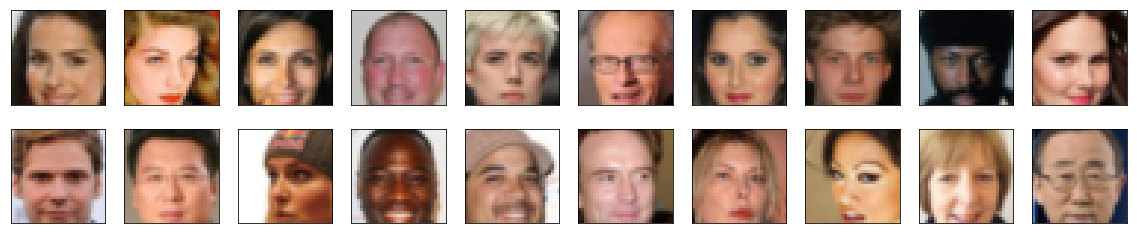

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    """ Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1."""

    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x

    # x from [a..b] -> y from [0..1]: y  =  (x-a)/(b-a)
    # vice versa: x = y*(b-a) + a
    a, b = feature_range
    return x * (b - a)+ a


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.8588)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,
                           kernel_size, stride, padding, bias=False)

    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, img_size=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function

        conv0_dim = conv_dim
        conv1_dim = conv0_dim
        conv2_dim = conv_dim * 2
        conv3_dim = conv_dim * 4
        final_img_size = img_size // 8

        # complete init function
        self.conv0 = conv(3, conv0_dim, kernel_size=3, stride=1, padding=1, batch_norm=False) # 32x32 ->32x32
        self.conv1 = conv(conv0_dim, conv1_dim, batch_norm=True) # 32x32 -> 16x16

        self.conv2 = conv(conv1_dim, conv2_dim, batch_norm=True) # 16 x 16 -> 8x8
        self.conv3 = conv(conv2_dim, conv3_dim, batch_norm=True) # 8x8 -> 4x4
        self.fc = nn.Linear(conv3_dim * (final_img_size ** 2), 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        batch_size = x.shape[0]
        # complete forward function

        x = self.lrelu(self.conv0(x))
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))

        x = self.fc(x.view(batch_size, -1))

        # no sigmoid, will be part of criterion
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers

    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

    # append conv layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.initial_img_size = img_size // 8
        conv0_dim = conv_dim * 4
        conv1_dim = conv_dim * 2
        conv2_dim = conv_dim
        conv3_dim = conv2_dim

        self.fc = nn.Linear(z_size, conv0_dim * (self.initial_img_size ** 2)) # 1, -> 4x4
        self.conv0 = deconv(conv0_dim, conv1_dim, batch_norm=True) # 4x4 -> 8x8
        self.conv1 = deconv(conv1_dim, conv2_dim, batch_norm=True) # 8x8 -> 16 x 16
        self.conv2 = deconv(conv2_dim, conv3_dim, batch_norm=True) # 16x16 -> 32x32
        self.conv3 = deconv(conv3_dim, 3, kernel_size=3, stride=1, padding=1, batch_norm=False) # 32x32 -> 32x32

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        batch_size = x.shape[0]

        x = self.fc(x)
        x = F.relu(self.conv0(x.view(batch_size, -1, self.initial_img_size, self.initial_img_size)), )
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.tanh(self.conv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
 def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(mean=0, std=0.02)


## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = d_conv_dim
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (conv0): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), str

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.shape[0]

    labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels * 0.9) # smooth labels, is recommended for better model converging
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params according to DCGAN paper
lr = 0.0002
beta1=0.5 #momentum
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
import datetime
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images
            d_real_out = D(real_images)
            d_real_loss = real_loss(d_real_out)

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            d_fake_out = D(fake_images)
            d_fake_loss = fake_loss(d_fake_out)

            d_loss = d_real_loss + d_fake_loss
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            gen_images = G(z)
            d_gen_images_out = D(gen_images)
            g_loss = real_loss(d_gen_images_out)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('|{}| Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    datetime.datetime.now(),
                    epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [32]:
# !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b0dea96_workspace-utils/workspace-utils.py
# !mv workspace-utils.py workspace_utils.py
!ls workspace_utils.py

--2020-06-01 20:00:11--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b0dea96_workspace-utils/workspace-utils.py
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540 (1.5K) []
Saving to: ‘workspace-utils.py’

workspace-utils.py  100%[===================>]   1.50K  --.-KB/s    in 0s      

2020-06-01 20:00:11 (15.0 MB/s) - ‘workspace-utils.py’ saved [1540/1540]

workspace_utils.py


In [24]:
# set number of epochs 
n_epochs = 100

# ~1.5 min per epoch
# batch size: 128
# img 32, first conv layer 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
from workspace_utils import active_session

with active_session():
    losses = train(D, G, n_epochs=n_epochs)

|2020-06-02 10:50:57.665236| Epoch [    1/  100] | d_loss: 0.7861 | g_loss: 2.4207
|2020-06-02 10:51:08.660031| Epoch [    1/  100] | d_loss: 0.4397 | g_loss: 2.6688
|2020-06-02 10:51:19.614608| Epoch [    1/  100] | d_loss: 0.6518 | g_loss: 2.9781
|2020-06-02 10:51:30.549015| Epoch [    1/  100] | d_loss: 0.4979 | g_loss: 3.1398
|2020-06-02 10:51:41.448131| Epoch [    1/  100] | d_loss: 0.6111 | g_loss: 2.5088
|2020-06-02 10:51:52.272596| Epoch [    1/  100] | d_loss: 0.6922 | g_loss: 2.1308
|2020-06-02 10:52:03.153537| Epoch [    1/  100] | d_loss: 0.4714 | g_loss: 2.5808
|2020-06-02 10:52:13.980955| Epoch [    1/  100] | d_loss: 0.4687 | g_loss: 3.2106
|2020-06-02 10:52:24.858481| Epoch [    1/  100] | d_loss: 0.5014 | g_loss: 2.8441
|2020-06-02 10:52:35.226938| Epoch [    2/  100] | d_loss: 0.4328 | g_loss: 3.6386
|2020-06-02 10:52:46.094744| Epoch [    2/  100] | d_loss: 0.4223 | g_loss: 2.8081
|2020-06-02 10:52:57.023362| Epoch [    2/  100] | d_loss: 0.6666 | g_loss: 4.1398
|202

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

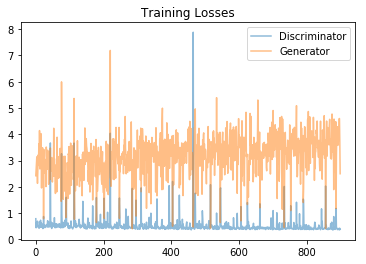

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [27]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

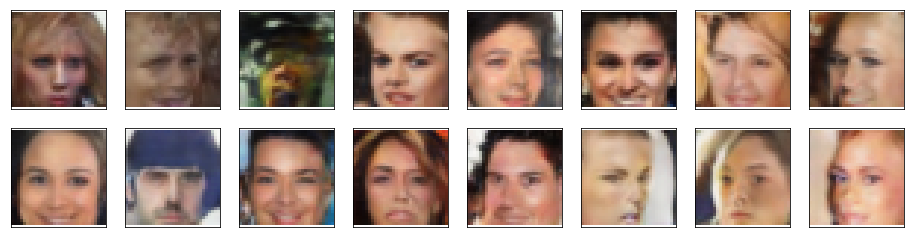

In [29]:
_ = view_samples(-1, samples)

Results for different epochs, looks like even for first epochs they are good enough, at leas much better to other model which I tried initially with fewer layers

In [6]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

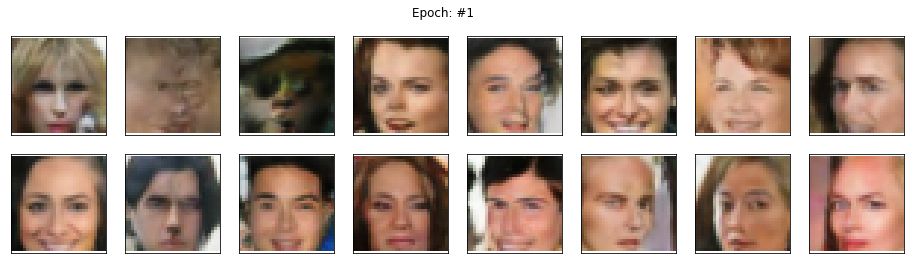

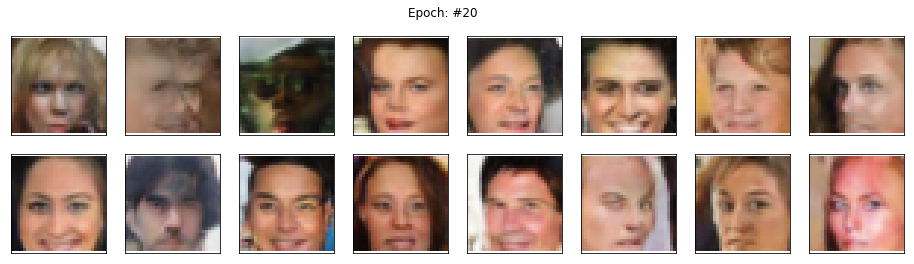

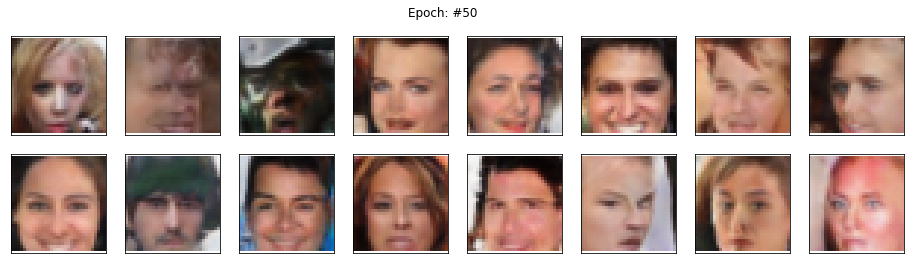

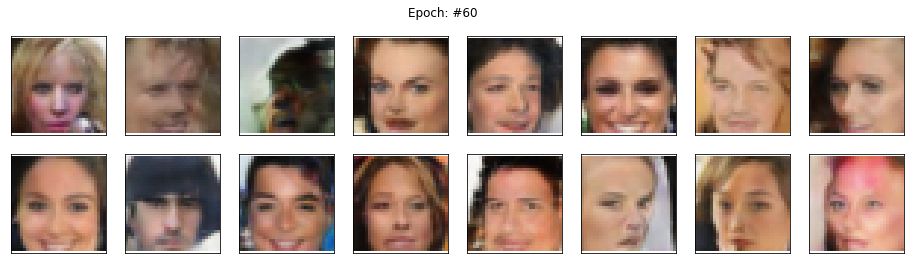

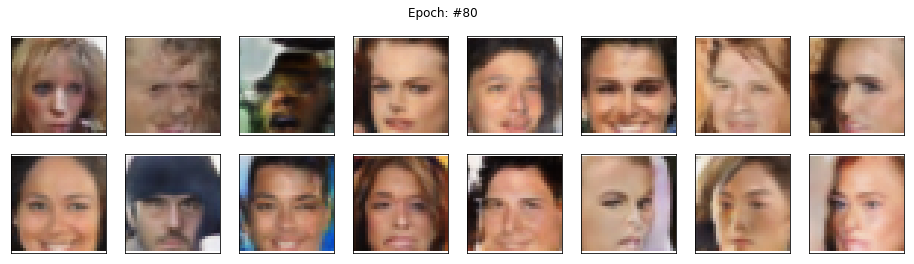

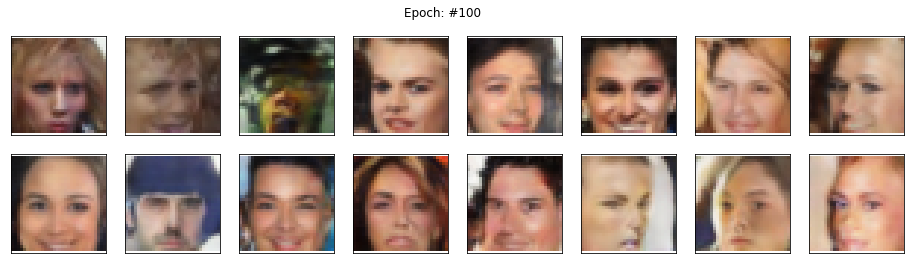

In [16]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    fig.suptitle("Epoch: #{}".format(1+epoch))
    plt.show()
        
_ = view_samples(0, samples)
_ = view_samples(19, samples)
_ = view_samples(49, samples)
_ = view_samples(59, samples)
_ = view_samples(79, samples)
_ = view_samples(99, samples)

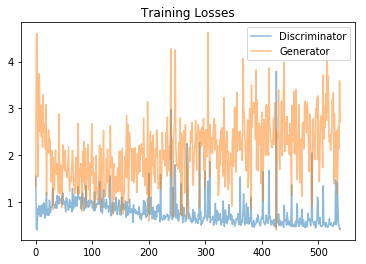

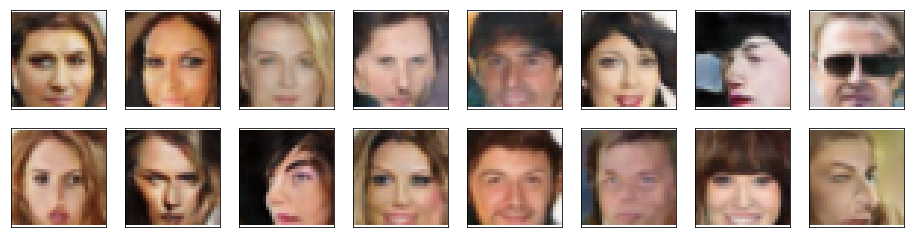

In [22]:
# Same model, but result after 60 epochs (separate launch):
# here we see zoomed learning curve compared to prev launc

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

* Image resolution and detalization is quite low, it is because we use just 32x32 images. E.g. even 64x64 images which was used in DCGAN paper look much better and not so blury. So it is desired generate images with larger resolution and this will require to make model more complicated, e.g. with more convolution layers. 

* In general faces are realistic and I was quite surprised by the result

* Seems background introduce some bias and artifacts, so better to use faces w/o background for training

* Also some faces looks weird because training set is a mixture if photos taken in face or from side. Better to have more consistent dataset. 

* Dataset is indeed biased, faces are mostly smiling white young females with make-up. We need to get large dataset with people of color and more sex and age balanced. We need to have people without make-up too and with different mimics

* Model gives good results even for small number of epochs. Also we could play with different optimizers, e.g. SGD and try to check different beta1/beta2 momentums for Adam optimizer, different learning rates. I've taken params recommened by the original DCGAN paper and they work ok for me, also my model is slightly different.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

# Extra

1) I've tried different minibatch sizes, but epoch time was almost same, e.g for sizes 128, 512, 1024 - 1 min each time. I expected some noticeable perfomance boost. DCGAN paper suggest 128 so I decide to use it in any case not speed improvemnts. Not really clear why it is so. If 512 doesn't fit GPU mem seems I should get OOM, but not auto-split in sequentially processed samall chunks (matrix operations on smaller chunks and merging result). Could you explain why it could behave this way?

2) I've tried different models, the initial one was closer to DCGAN paper and has one convolution level less (fist one). I.e. doesn't have conv level with kernel=3 and stride=1. When I launched it for 80 epochs seems it stopped learning at some point and generator got a trick how to fool discriminator. Unfortunatelly due to bug in a code faces preview below learning curve doesn't belong to this run and likely from run with 10 epochs. In any case seems it isn't good thus I decided to modify a model and make it more complicated. Do you have any comments for the learning curve below, I'm I right that it is bad pattern for GAN learning?

In [97]:
# # set number of epochs 
# n_epochs = 80

# # 1 min per epoch
# # batch size: 128, conv 64
# # img 32, first conv layer 128

# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """
# # call training function
# from workspace_utils import active_session

# with active_session():
#     losses = train(D, G, n_epochs=n_epochs)

|2020-06-01 20:46:08.458022| Epoch [    1/   80] | d_loss: 1.3097 | g_loss: 1.2617
|2020-06-01 20:46:15.006622| Epoch [    1/   80] | d_loss: 0.4228 | g_loss: 4.1455
|2020-06-01 20:46:21.516384| Epoch [    1/   80] | d_loss: 1.1002 | g_loss: 4.5013
|2020-06-01 20:46:28.020155| Epoch [    1/   80] | d_loss: 0.6667 | g_loss: 1.9661
|2020-06-01 20:46:34.554267| Epoch [    1/   80] | d_loss: 0.7939 | g_loss: 2.1842
|2020-06-01 20:46:41.088566| Epoch [    1/   80] | d_loss: 0.7294 | g_loss: 2.4272
|2020-06-01 20:46:47.573353| Epoch [    1/   80] | d_loss: 0.8347 | g_loss: 1.8960
|2020-06-01 20:46:54.092310| Epoch [    1/   80] | d_loss: 0.7669 | g_loss: 1.5189
|2020-06-01 20:47:00.614471| Epoch [    1/   80] | d_loss: 1.5345 | g_loss: 4.6752
|2020-06-01 20:47:06.814989| Epoch [    2/   80] | d_loss: 0.7935 | g_loss: 1.7340
|2020-06-01 20:47:13.292302| Epoch [    2/   80] | d_loss: 0.9378 | g_loss: 1.8174
|2020-06-01 20:47:19.820300| Epoch [    2/   80] | d_loss: 0.8515 | g_loss: 1.5320
|202

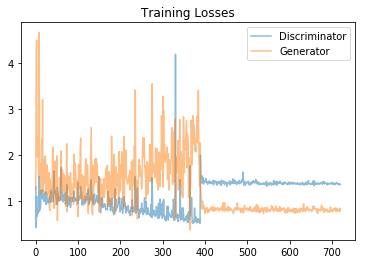

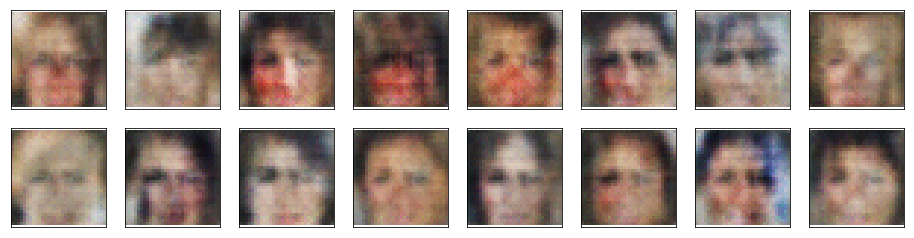

In [98]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
_ = view_samples(-1, samples)

Same model as before but for 40 epochs, seems works also ok, but I'd like results of my final model a bit more.

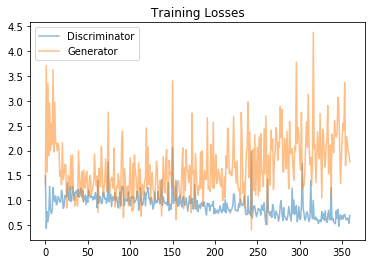

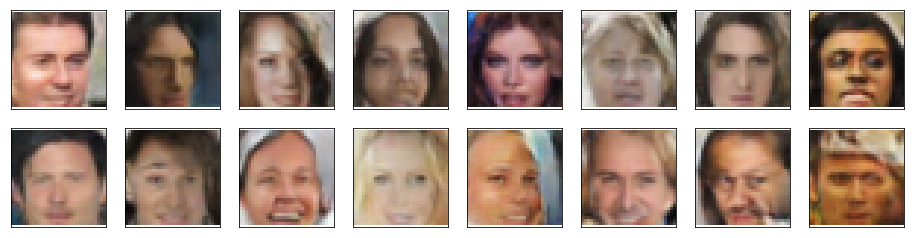

In [43]:
# Load samples from generator, taken while training
with open('train_samples_m1_40.pkl', 'rb') as f:
    samples = pkl.load(f)        
_ = view_samples(-1, samples)